In [22]:
import pandas as pd 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler 

In [118]:
fifty_coefficients_df = pd.read_csv('./Threshold_DBs/50_pivoted_model_coefficients_for_all_features.csv')
coefficients_df = pd.read_csv('./pivoted_model_coefficients_for_all_features.csv')

coefficients_df_cleaned = coefficients_df.dropna() 
originalDFSet = coefficients_df['County'].unique()
cleanedDF = coefficients_df_cleaned['County'].unique()

fifty_ds_cleaned = fifty_coefficients_df.dropna()
fifty_coefficients_df = fifty_coefficients_df['County'].unique()
fifty_ds_cleaned = fifty_ds_cleaned['County'].unique()

print(set(originalDFSet) - set(cleanedDF))
print(set(fifty_coefficients_df) - set(fifty_ds_cleaned))

{'Montgomery', 'Jeff Davis', 'Ben Hill', 'Jenkins', 'Taliaferro', 'Bacon'}
{'Montgomery', 'Jeff Davis', 'Ben Hill', 'Jenkins', 'Taliaferro', 'Bacon'}
{'Towns', 'Lamar', 'Telfair', 'Greene', 'Sumter', 'Glascock', 'Taliaferro', 'Laurens', 'Stephens', 'Jones', 'Long', 'Webster', 'Dodge', 'Appling', 'Jeff Davis', 'Franklin', 'Morgan', 'Calhoun', 'Ben Hill', 'McIntosh', 'Bacon', 'Upson', 'Montgomery', 'Stewart', 'Heard', 'Chattooga', 'Dawson', 'Jenkins', 'Putnam', 'Quitman', 'Baker', 'Atkinson', 'Chattahoochee', 'Jasper', 'Monroe', 'Union', 'Pike', 'Bulloch', 'Cook', 'Mitchell', 'Lee', 'Clay'}


Visual Depiction of the Features vs. Counties TradeOff: 

- A **lower NaN threshold** (e.g., 30% or less):
  - I only include features in my analysis that have a relatively low proportion of missing values. This typically means that each feature I retain is more robustly represented across counties since there's sufficient data.
  - The result is that more counties can be included because I am only considering features that these counties have enough data for.
  - However, I'll have fewer features to analyze because I've excluded those with higher amounts of missing data.

- A **higher NaN threshold** (e.g., 50% or less):
  - I've included features with a higher proportion of missing values. This allows me to retain a larger number of features for your analysis.
  - The drawback is that some counties may not have enough data to be included for these additional features, which leads to their exclusion from the analysis.
  - This can result in a dataset with more features but fewer counties.



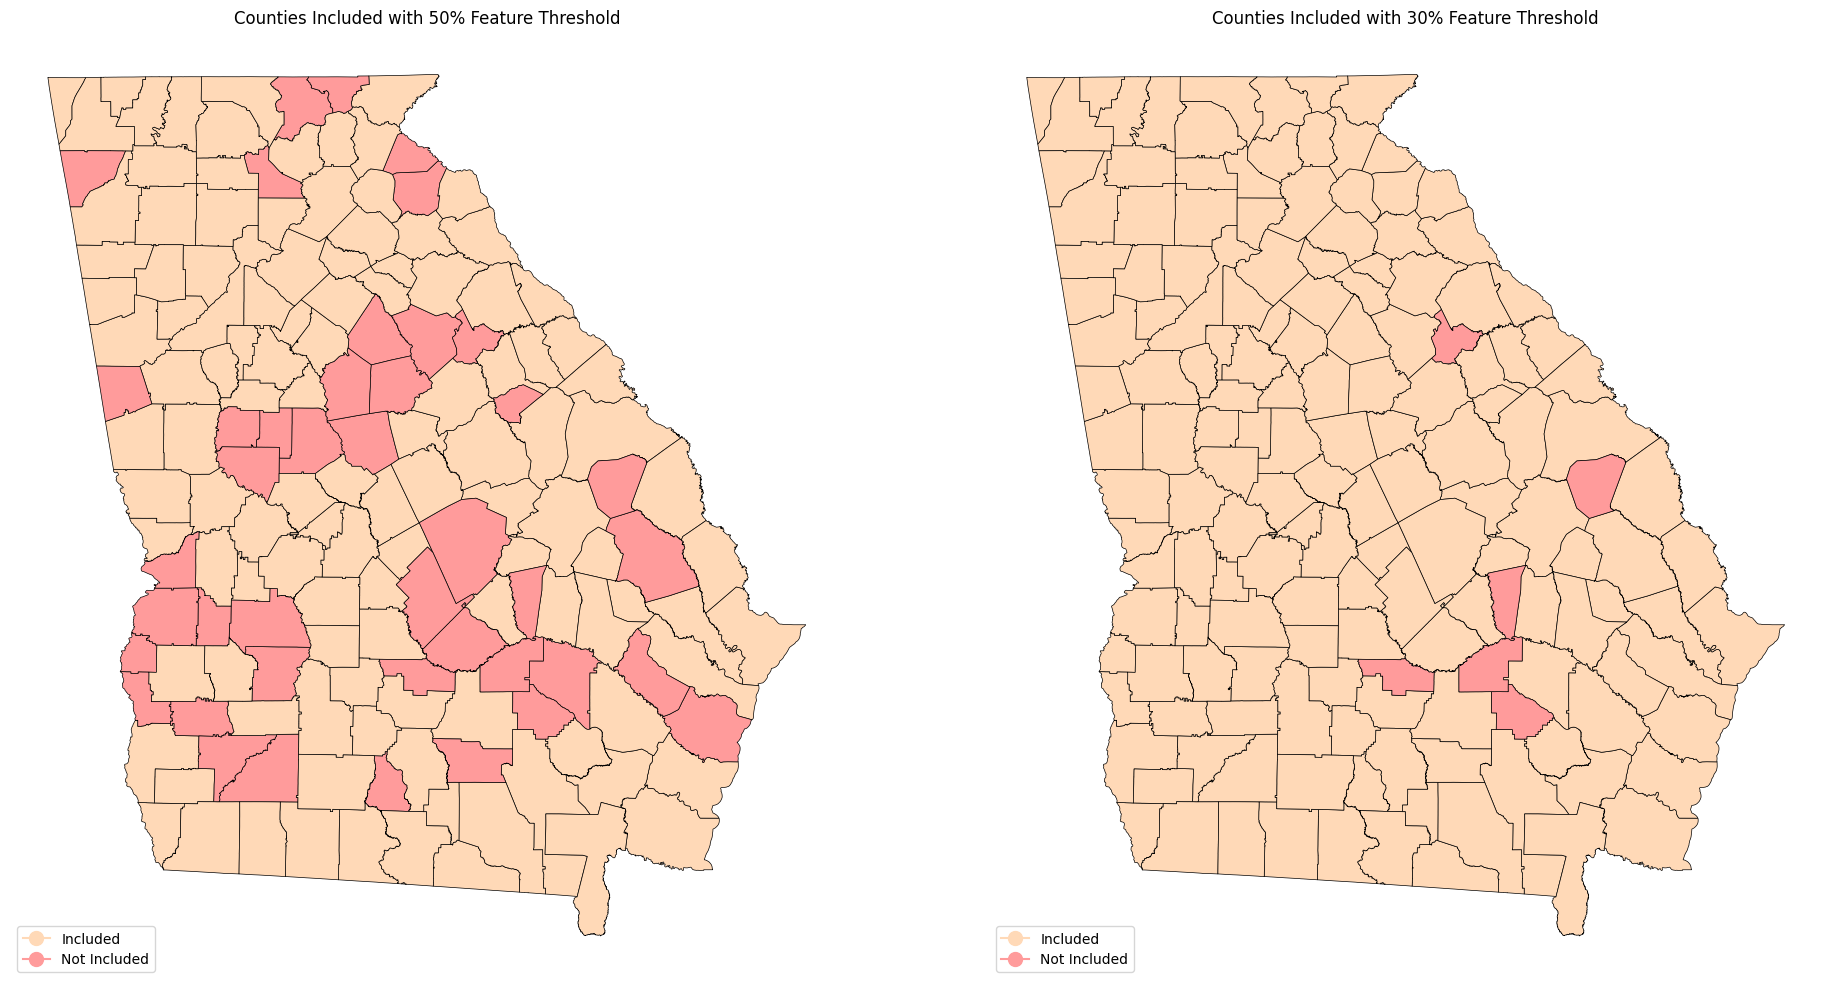

In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Load datasets
cleaned_data_table = pd.read_csv("pivot_wide_format_data_cleaned.csv")
coefficients_50_threshold = pd.read_csv('./Threshold_DBs/50_pivoted_model_coefficients_for_all_features.csv').dropna()
coefficients_30_threshold = pd.read_csv('pivoted_model_coefficients_for_all_features.csv').dropna()

# GeoDataFrame of the Georgia counties shapefile
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Flags for whether counties are included based on the number of features meeting the threshold
geo_data['included_50_threshold'] = geo_data['NAME10'].isin(coefficients_50_threshold['County'].unique()).astype(int)
geo_data['included_30_threshold'] = geo_data['NAME10'].isin(coefficients_30_threshold['County'].unique()).astype(int)

# Define color mappings (pastel blue for included, pastel green for not included)
color_map = {0: '#FFD9B7', 1: '#FF9B9B'} 

# Manual legend elements for the custom labels without scale
legend_elements = [
    Line2D([0], [0], marker='o', color=color_map[0], label='Included', markerfacecolor=color_map[0], markersize=10),
    Line2D([0], [0], marker='o', color=color_map[1], label='Not Included', markerfacecolor=color_map[1], markersize=10),
]

# Create maps to show included counties for each threshold
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

# 50% Threshold map
geo_data.plot(column='included_50_threshold', cmap=plt.matplotlib.colors.ListedColormap([color_map[x] for x in geo_data['included_50_threshold'].unique()]),
              ax=axs[0], edgecolor='black', linewidth=0.5)  # Adjust edge color and line width as needed
axs[0].set_title('Counties Included with 50% Feature Threshold')
axs[0].axis('off')
axs[0].legend(handles=legend_elements, loc='lower left')

# 30% Threshold map
geo_data.plot(column='included_30_threshold', cmap=plt.matplotlib.colors.ListedColormap([color_map[x] for x in geo_data['included_30_threshold'].unique()]),
              ax=axs[1], edgecolor='black', linewidth=0.5)  # Adjust edge color and line width as needed
axs[1].set_title('Counties Included with 30% Feature Threshold')
axs[1].axis('off')
axs[1].legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()


First Step: Visualizations and Principal Component Analysis 

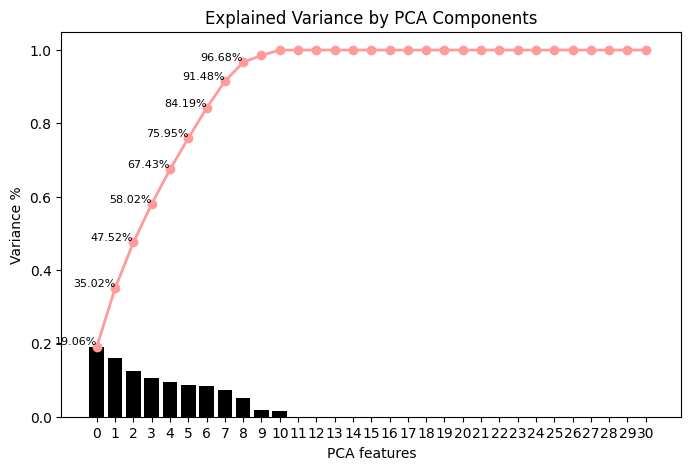

Number of components to explain 95.0% variance: 9


In [200]:
from sklearn.decomposition import PCA

features = coefficients_df_cleaned.columns.drop('County') 
X = coefficients_df_cleaned[features].values
variance_threshold = 0.95

# Your existing code to fit PCA and plot the individual explained variance
pca = PCA()
pca.fit(X)

features = range(pca.n_components_)
plt.figure(figsize=(8, 5))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.title('Explained Variance by PCA Components')

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance trend line
plt.plot(features, cumulative_variance, color='#FF9B9B', marker='o', linestyle='-', linewidth=2, label='Cumulative Explained Variance')

# Annotate the points for the first 9 features or until cumulative variance reaches 100%
for i, v in enumerate(cumulative_variance):
    if v < 1.0 and i < 9:  # Check if the cumulative variance is less than 100% and within the first 9 features
        plt.text(i, v, f"{v:.2%}", fontsize=8, ha='right', va='bottom')


# Find the number of components for the desired threshold and add a vertical line at this point
components_for_threshold = np.argmax(cumulative_variance >= variance_threshold) + 1

# Show the plot
plt.show()

# Print the number of components required to explain the desired threshold of variance
print(f"Number of components to explain {variance_threshold*100}% variance: {components_for_threshold}")


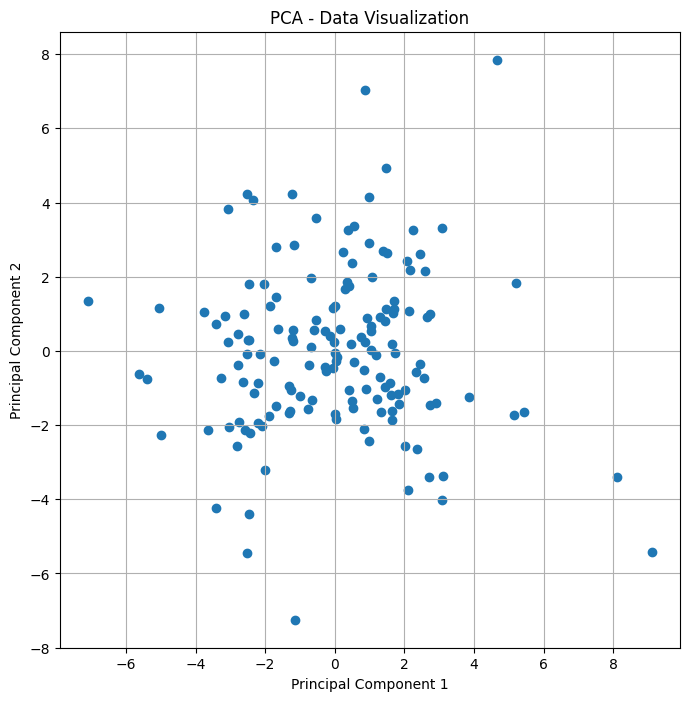

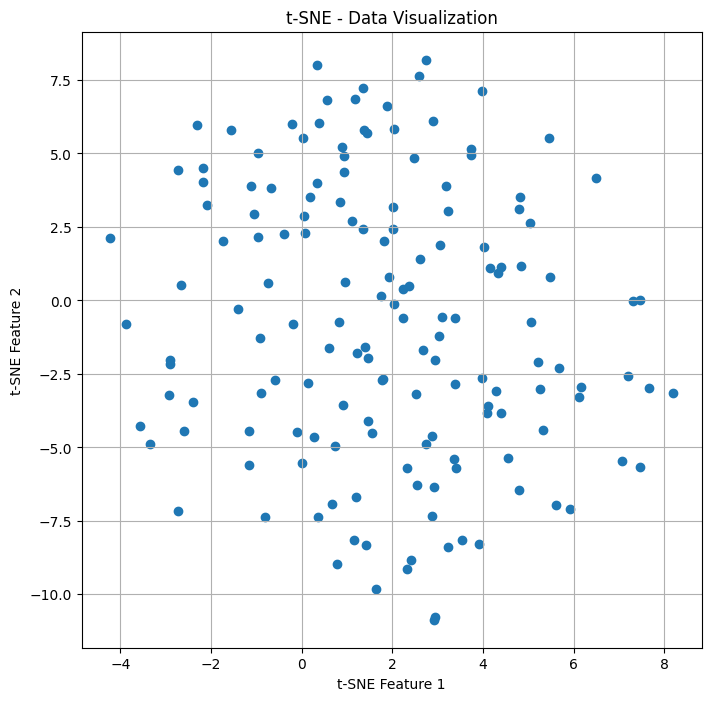

In [193]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming coefficients_df_cleaned is your DataFrame with features you want to plot
features = coefficients_df_cleaned.columns.drop('County') 
X = coefficients_df_cleaned[features].values

# Initialize PCA and transform your data to the first two principal components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the PCA result
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA - Data Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

from sklearn.manifold import TSNE

# Initialize t-SNE and transform your data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE result
plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE - Data Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.grid(True)
plt.show()




Second Step: Clustering 

Determined the optimal number of clusters using nbclust package: R, elbow method, sillhouette scores graph 

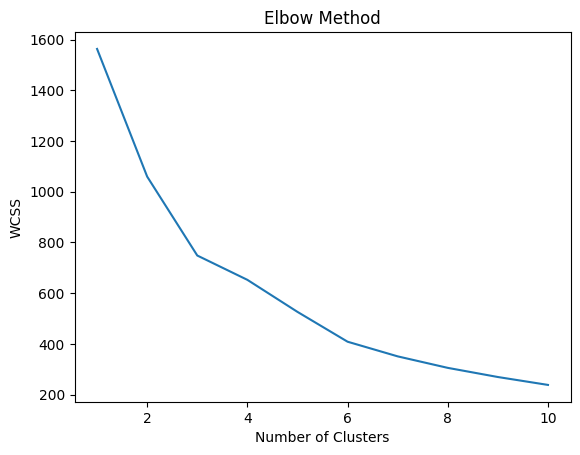

In [207]:
coefficients_df_cleaned = coefficients_df.dropna() 

features_to_scale = coefficients_df_cleaned.columns.drop('County')
#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title("Elbow Method")
plt.xlabel('Number of Clusters')
plt.ylabel("WCSS")
plt.show() 

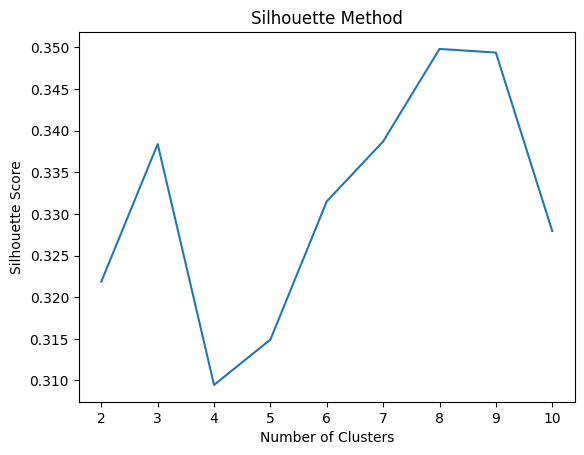

In [204]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

coefficients_df_cleaned = coefficients_df.dropna() 

features_to_scale = coefficients_df_cleaned.columns.drop('County')

#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

silhouette_scores = []
for i in range(2, 11):  # Silhouette score is not defined for a single cluster
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2,11), silhouette_scores)
plt.title("Silhouette Method")
plt.xlabel('Number of Clusters')
plt.ylabel("Silhouette Score")
plt.show()


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15807/520827709.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



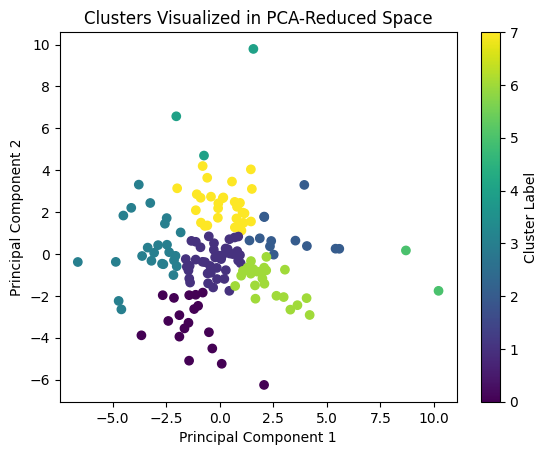

The average silhouette score is: 0.3497960728760207


In [217]:
from sklearn.cluster import KMeans


coefficients_df_cleaned = coefficients_df.dropna() 
features_to_scale = coefficients_df_cleaned.columns.drop('County') 

#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Let's assume you've chosen 3 as the optimal number of clusters
n_clusters = 8

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict cluster indices
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to your original DataFrame for further analysis
coefficients_df_cleaned['Cluster'] = cluster_labels

# Now you can analyze the results
# Here's a simple visualization using PCA-reduced data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clusters Visualized in PCA-Reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

from sklearn.metrics import silhouette_score

# Assuming 'X' is your features matrix and 'cluster_labels' are the labels from your clustering
silhouette_avg = silhouette_score(X_pca, cluster_labels)

print(f"The average silhouette score is: {silhouette_avg}")


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15807/1449515199.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



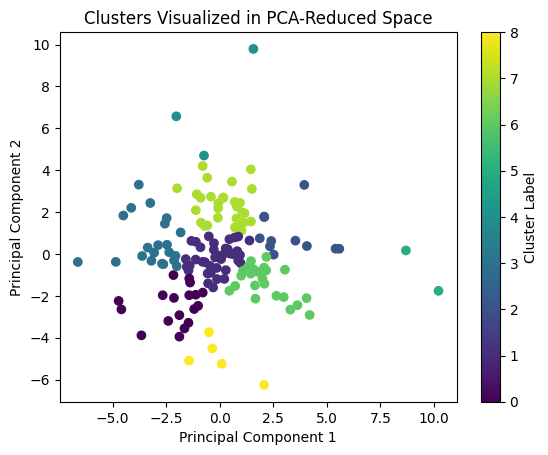

The average silhouette score is: 0.3493546432506298


In [215]:
from sklearn.cluster import KMeans


coefficients_df_cleaned = coefficients_df.dropna() 
features_to_scale = coefficients_df_cleaned.columns.drop('County') 

#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Let's assume you've chosen 3 as the optimal number of clusters
n_clusters = 9

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict cluster indices
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to your original DataFrame for further analysis
coefficients_df_cleaned['Cluster'] = cluster_labels

# Now you can analyze the results
# Here's a simple visualization using PCA-reduced data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clusters Visualized in PCA-Reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

from sklearn.metrics import silhouette_score

# Assuming 'X' is your features matrix and 'cluster_labels' are the labels from your clustering
silhouette_avg = silhouette_score(X_pca, cluster_labels)

print(f"The average silhouette score is: {silhouette_avg}")


In [195]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming X is your dataset after PCA
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Define ranges for eps and min_samples to test
eps_values = np.arange(0.1, 100.0, 1.0)  # Start from 0.1 to avoid the invalid parameter error
min_samples_values = range(2, 100)  

best_eps = None
best_min_samples = None
best_silhouette = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN with current eps and min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_pca)
        
        # Ignore the combination if only one or no clusters are found
        if len(np.unique(clusters)) < 2 or (clusters == -1).all():
            continue
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(X_pca, clusters)
        
        # Update best parameters if current silhouette score is the best
        if silhouette_avg > best_silhouette:
            best_eps = eps
            best_min_samples = min_samples
            best_silhouette = silhouette_avg

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best silhouette score: {best_silhouette}")


Best eps: 4.1
Best min_samples: 5
Best silhouette score: 0.6153066457506404


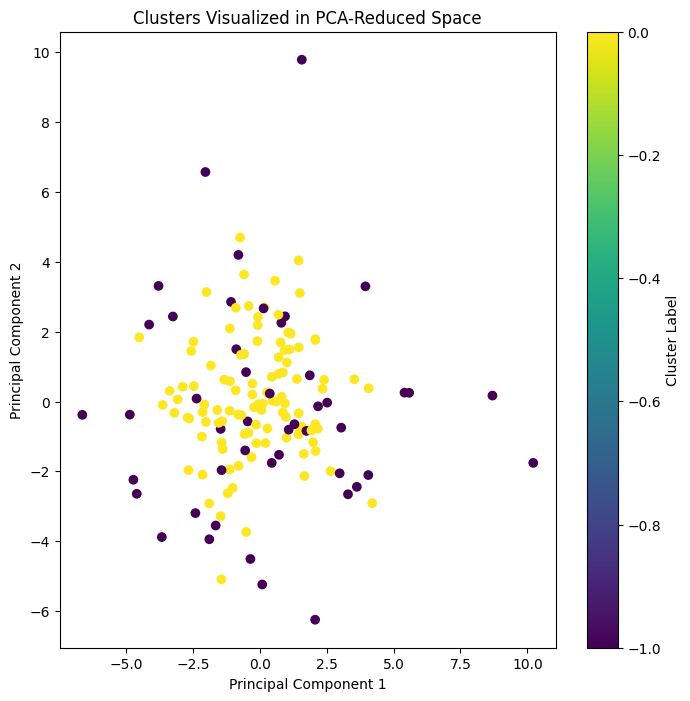

In [223]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Assuming 'X' is your dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Run DBSCAN
dbscan = DBSCAN(eps=4.1, min_samples=5)
clusters = dbscan.fit_predict(X)

# Plot
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter, label='Cluster Label')
plt.title('Clusters Visualized in PCA-Reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


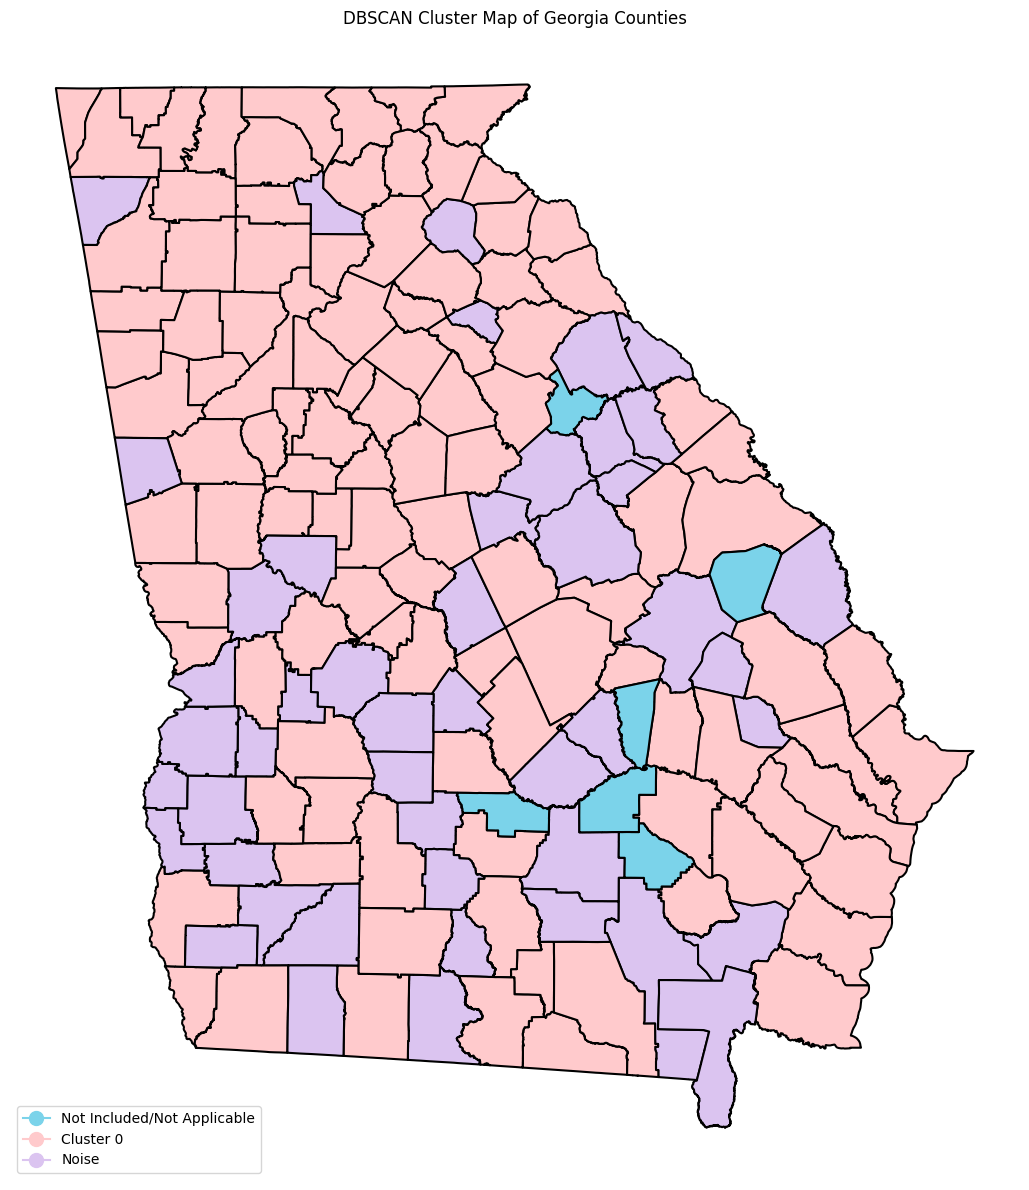

In [236]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Load the GeoDataFrame of Georgia counties
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Create a DataFrame from the clusters
cluster_df = pd.DataFrame({'County': coefficients_df_cleaned['County'], 'Cluster': clusters})

# Merge the geographical data with the cluster data
geo_data = geo_data.merge(cluster_df, how='left', left_on='NAME10', right_on='County')

# Define color mappings for cluster and noise
color_map = {0: '#FFCACC', -1: '#DBC4F0'}  # pink for cluster 0, purple for noise

# Assign colors to counties based on the cluster they belong to
geo_data['color'] = geo_data['Cluster'].apply(lambda x: color_map.get(x, '#7BD3EA'))  # default light blue for counties not in the dataset

# Create manual legend elements for the custom labels
legend_elements = [
    Line2D([0], [0], marker='o', color='#7BD3EA', label='Not Included/Not Applicable', markerfacecolor='#7BD3EA', markersize=10),
    Line2D([0], [0], marker='o', color=color_map[0], label='Cluster 0', markerfacecolor=color_map[0], markersize=10),
    Line2D([0], [0], marker='o', color=color_map[-1], label='Noise', markerfacecolor=color_map[-1], markersize=10),
]

# Plotting the map with clusters, including thicker borders for the counties
fig, ax = plt.subplots(1, figsize=(12, 12))
geo_data.plot(color=geo_data['color'], ax=ax, edgecolor='black', linewidth=1.5)  # Adjust edge color and line width as needed

# Set title and axes properties
ax.set_title('DBSCAN Cluster Map of Georgia Counties')
ax.axis('off')

# Add the custom legend to the map
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()
